In [1]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
import sys 
from glob import glob 
import vaex
from hammer import Model
current = abspath("")
root_dir = abspath(join(current, '..', '..'))
root_data_dir = join(root_dir, "Data")
import sys
if not root_dir in sys.path: 
    sys.path.append(root_dir)

In [2]:
from utils import (style, get_params,
                   get_initial_position_normal, get_data, generate_init)

style()

In [3]:
z_dir_path = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'z')
w_dir_path = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'z')
z_dir_path, w_dir_path

('/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z')

In [4]:
name = "Baryon"
baryon_dir = join(root_data_dir, name)
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [28]:
index = 5
z_files = glob(join(z_dir_path, "z*"))
z_files.sort()
w_files = glob(join(w_dir_path, "w*"))
w_files.sort()
name = z_files[index].split("/")[-1].replace(".hdf5", "").replace("z_", "")
zdata = get_data(z_files[index])
wdata = get_data(w_files[index])

zdata, wdata, name

((array([-298.53675849, -270.11780482, -241.69885114, -213.27989746,
         -184.86094378, -156.4419901 , -128.02303643,  -99.60408275,
          -71.18512907,  -42.76617539,  -14.34722171,   14.07173196,
           42.49068564,   70.90963932,   99.328593  ,  127.74754668,
          156.16650035,  184.58545403,  213.00440771,  241.42336139,
          269.84231507,  298.26126874]),
  array([0.25470369, 0.32368593, 0.40062767, 0.49083523, 0.54655166,
         0.75615157, 0.75349841, 0.93126035, 0.91799454, 1.07718434,
         1.00289577, 0.98167046, 0.87289076, 0.82513382, 0.68451616,
         0.68982248, 0.4643036 , 0.36083022, 0.33695175, 0.27858216,
         0.16980246, 0.14592399]),
  array([0.02599559, 0.02930515, 0.03260262, 0.03608692, 0.03808006,
         0.04479055, 0.0447119 , 0.049707  , 0.04935169, 0.05345976,
         0.05158339, 0.05103462, 0.04812403, 0.04678905, 0.04261611,
         0.04278097, 0.03509805, 0.03094094, 0.02989963, 0.02718683,
         0.02122531, 0.0196

# run_mcmc

In [9]:
from tqdm import tqdm
from time import time
from enum import Enum
from hammer import Model as MCMC_Model
 
class Model(Enum):
    DM = "DM"
    DDDM = "DDDM"
    NO = "NO"

func_dict = {
    "DM": MCMC_Model.DM,
    "DDDM": MCMC_Model.DDDM,
    "NO": MCMC_Model.NO,
}

def mcmc(model: Model, z_path: str, w_path: str, **options):
    """
    Run MCMC

    Parameters
    ----------
    model: `Model` = `Model.DM`, `Model.DDDM`, or `Model.NO` \n
    z_path: `str` = path to z data \n
    w_path: `str` = path to w data \n
    options:
        step0: `int` = 500 \n
        step: `int` = 2000 \n
        burn: `int` = 1000 \n
        it: `int` = 3 \n
        thin: `int` = 20 \n
        verbose: `bool` = True \n
        m: `int` = 10 (multiplier, `nwalker = m*ndim`)
        
    Returns
    -------
    result: `dict` = { \n
        indexes: `ndarray(shape(nparam))`, \n
        labs: `ndarray(shape(nparam))`, \n
        labels: `ndarray(shape(nparam))`, \n
        chain: `ndarray(shape(nstep,nwalker,nparam))` \n
    }
    """
    step0 = options.get("step0", 100)
    step = options.get("step", 2000)
    burn = options.get("burn", 1000)
    it = options.get("it", 3)
    thin = options.get("thin", 20)
    verbose = options.get("verbose", True)
    m = options.get("m", 10)
    func = func_dict[model.value]
    if verbose: print("running...")
    name = z_path.split("/")[-1].replace(".hdf5", "").replace("z_", "")
    zdata = get_data(z_path)
    wdata = get_data(w_path)
    
    init = generate_init(model)
    locs = init['locs']
    scales = init['scales']    
    indexes = init['indexes']
    labs = init['labs']
    labels = init['labels']

    ndim = len(locs)
    nwalker = m*ndim
    if verbose: print(f"mcmc... {name}")
    p0 = func.generate_p0(nwalker, locs, scales)
    for i in tqdm(range(it), desc="mcmc"):
        t0 = time()
        chain = func.mcmc(step0, zdata, wdata, p0, locs, scales, dz=1., parallel=True, verbose=verbose)
        t1 = time()
        if verbose: print(f"{i}: first half mcmc done {np.round(t1-t0, 2)} s")
        locs_normal, scales_normal = get_initial_position_normal(model, chain=chain[int(step0/2):])
        p0 = func.generate_p0(nwalker, locs_normal, scales_normal, norm=True)
        t0 = time()
        chain = func.mcmc(step0, zdata, wdata, p0, locs, scales, dz=1., parallel=True, verbose=verbose)
        t1 = time()
        if verbose: print(f"{i}: second half mcmc done {np.round(t1-t0, 2)} s")
        p0 = chain[-1]
    chain = func.mcmc(burn, zdata, wdata, p0, locs, scales, dz=1., parallel=True, verbose=verbose)
    p0 = chain[-1]
    chain = func.mcmc(step, zdata, wdata, p0, locs, scales, dz=1., parallel=True, verbose=verbose)
    chain_thin = chain[::thin]
    return {
        "indexes": indexes,
        "labs": labs,
        "labels": labels,
        "chain": chain_thin
        }

In [10]:
result = mcmc(
    model=Model.DM,
    z_path=z_files[index],
    w_path=w_files[index],
    step0=50,
    step=100,
    burn=100,
    it=2,
    thin=1,
    m=3
)

result.keys()

running...
mcmc... 313


mcmc:   0%|          | 0/2 [00:00<?, ?it/s]

0: first half mcmc done 0.61 s
[range(0, 12), 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


mcmc:  50%|█████     | 1/2 [00:01<00:01,  1.19s/it]

0: second half mcmc done 0.57 s
1: first half mcmc done 0.51 s
[range(0, 12), 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


mcmc: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

1: second half mcmc done 0.52 s


dict_keys(['indexes', 'labs', 'labels', 'chain'])

In [13]:
chain_thin = result['chain']
indexes = result['indexes']
labs = result['labs']
labels = result['labels']
step, nwalker, ndim = chain_thin.shape
step, nwalker, ndim

(100, 102, 34)

# plot_chain

In [15]:
from typing import List

def plot_chain(params: np.ndarray, labels: List[str], **options: dict):
    """required:
            params: `ndarray(shape=(nstep, nwalker, nparam))` (from `get_params`) \n
            labels: `List[str]` \n
        options:
            burn: `int` = 0 \n
            figsize: `Tuple[int, int]` = (10, 10) \n
            path: `str` = None \n
            alpha: `float` = 0.1 \n
            dpi: `int` = 70 \n
            fig_kw: `Dict` = All additional keyword arguments for `.pyplot.figure`.
            """
    figsize = options.get('figsize', (10, 15))
    path = options.get('path', None)
    alpha = options.get('alpha', 0.1)
    dpi = options.get('dpi', 70)
    burn = options.get('burn', 0)
    fig_kw = options.get('fig_kw', {})

    fig, axes = plt.subplots(len(labels), figsize=figsize, sharex=True, **fig_kw)
    chain_burn = params[burn:]
    for i, label in tqdm(enumerate(labels)):
        ax = axes[i]
        ax.plot(chain_burn[:, :, i], "k", alpha=alpha)
        ax.set_xlim(0, len(chain_burn)-1)
        ax.set_ylabel(label)
        ax.yaxis.set_label_coords(-0.1, 0.5)
    if path is not None:
        fig.savefig(path, dpi=dpi)
    axes[-1].set_xlabel("step number")
    plt.show()

11it [00:00, 20.18it/s]


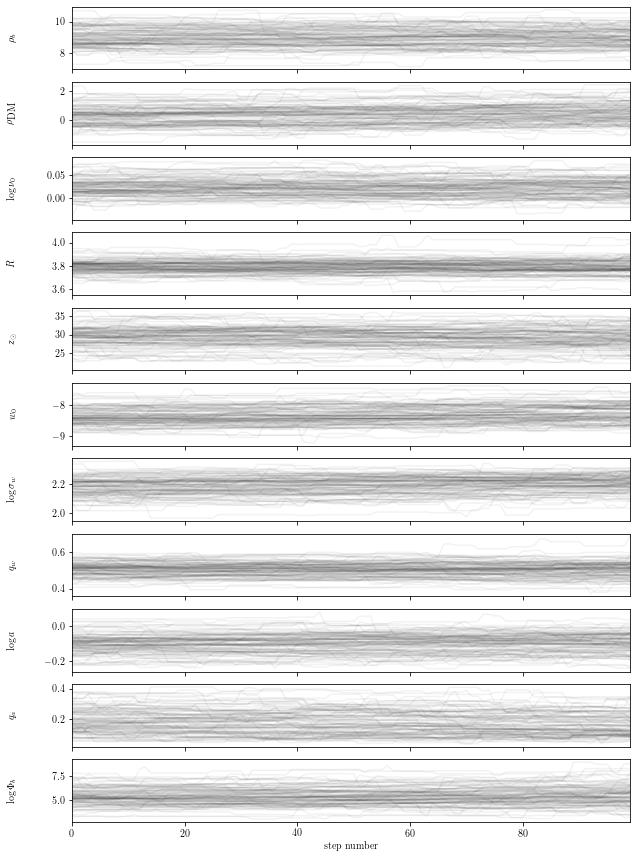

In [16]:
params = get_params(chain_thin, indexes, labs)

plot_chain(
    params=params,
    labels=labels,
    alpha=0.05
)

# plot_corner

In [18]:
from corner import corner

def plot_corner(params: np.ndarray, labels: List[str], **options: dict):
    """required: 
            params: `ndarray(shape=(nstep, nwalker, nparam))` (from `get_params`) \n
            labels: `List[str]` \n
        options:
            burn: `int` = 0 \n
            path: `str` = None \n
            dpi: `int` = 70 \n
            truths: `List[float]` = None (list of the real values) \n
            corner_kw: `Dict` = All additional keyword arguments for `corner.corner`."""
    
    burn = options.get('burn', 0)
    path = options.get('path', None)
    dpi = options.get('dpi', 70)
    truths = options.get('truths', None)
    corner_kw = options.get('corner_kw', {})

    fig = corner(params[burn:]. 
                    reshape((-1, len(labels))), 
                labels=labels,
                quantiles=[0.16, 0.5, 0.84],
                show_titles=True, title_fmt=".2f", 
                title_kwargs={"fontsize": 12},
                truths=truths,
                **corner_kw
                )
    if path is not None:
        fig.savefig(path, dpi=dpi)
    plt.show()

In [20]:
truths =[0.08889999999999998/1E-2, 
         1.60000000e-02/1E-3, 
         0.00000000e+00,  
         3.40000000e-03/1E-3,  
         3.00000000e+01,
        -7.00000000e+00,  
         2.30258509e+00,  
         5.00000000e-01,  
         0.00000000e+00,
         1.00000000e-01,  
         3.23168032e+00]

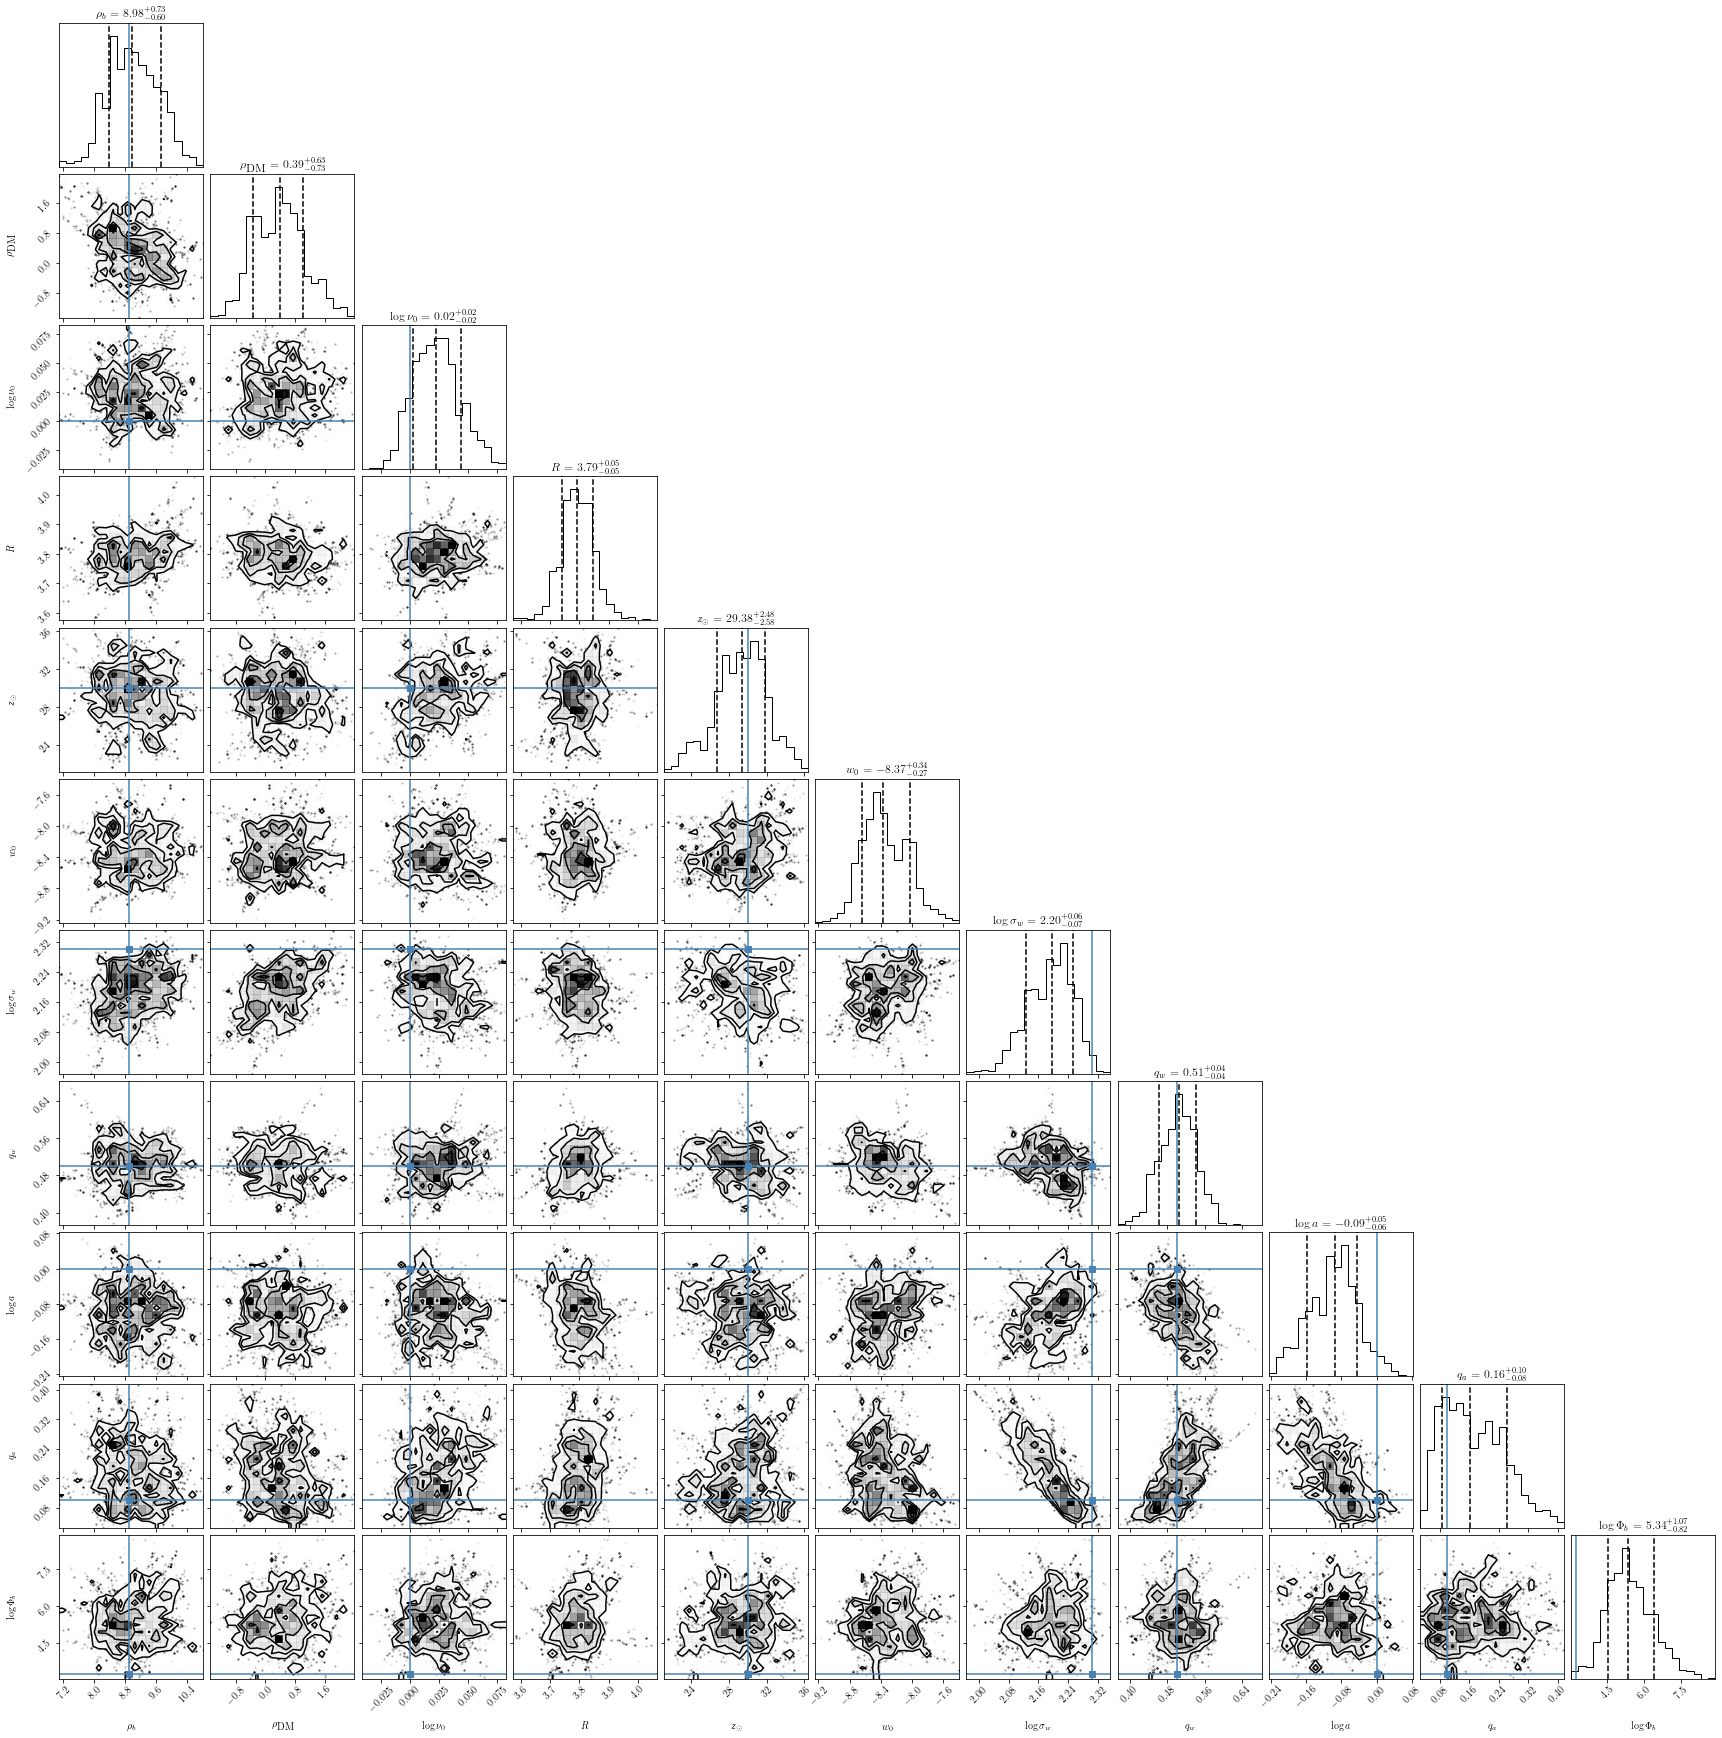

In [21]:
params = get_params(chain_thin, indexes, labs)

plot_corner(
    params=params,
    labels=labels,
    truths=truths
)

# plot_fit

In [32]:
from tqdm import tqdm

sigma_68 = 0.994458
sigma_90 = 1.644854
sigma_95 = 1.959964

def plot_fit(model: Model, flat_chain: np.ndarray, z_path: str, w_path: str, **options: dict):
    """required: 
            model: `Model` = Model.DM \n
            flat_chain: `ndarray(shape=(nsample, nparam))`\n
            z_path: `str` (path to z data)\n
            w_path: `str` (path to w data)\n
        options:
            res: `int` = 100 \n
            nsample: `int` = 5_000 \n
            figsize: `Tuple[int, int]` = (10, 10) \n
            alpha: `float` = 0.1 \n
            c: `str` = C0 \n
            log: `bool` = False \n
            dpi: `int` = 70 \n
            path: `str` = None \n
            fig_kw: `Dict` = All additional keyword arguments for `.pyplot.figure`.
            """
    res = options.get('res', 100)
    nsample = options.get('nsample', 5_000)
    figsize = options.get('figsize', (10, 10))
    alpha = options.get('alpha', 0.1)
    c = options.get('c', "C0")
    log = options.get('log', False)
    dpi = options.get('dpi', 70)
    path = options.get('path', None)
    fig_kw  = options.get('fig_kw', {})
    func = func_dict.get(model.value, MCMC_Model.DM)

    zdata = get_data(z_path)
    zmid, znum, zerr = zdata
    wdata = get_data(w_path)
    wmid, wnum, werr = wdata
    zs: np.ndarray[np.float64] = np.linspace(zmid.min()*1.1, zmid.max()*1.1, res)
    ws: np.ndarray[np.float64] = np.linspace(wmid.min()*1.1, wmid.max()*1.1, res)
    log_fws = np.empty((nsample, len(ws)))
    log_fzs = np.empty((nsample, len(zs)))
    for i in tqdm(range(nsample)):
        ind = np.random.randint(len(flat_chain))
        theta = flat_chain[ind]
        log_fws[i] = np.log(func.fw(ws, theta))
        log_fzs[i] = np.log(func.fz(zs, theta))

    fz_log_mean = log_fzs.mean(axis=0)
    fz_log_std = log_fzs.std(axis=0)
    fw_log_mean = log_fws.mean(axis=0)
    fw_log_std = log_fws.std(axis=0)

    fig, axes = plt.subplots(2, 1, figsize=figsize, **fig_kw)
    for ax, label, log_mean, log_std, vs, mid, num, err in zip(axes, ["z", "w"], [fz_log_mean, fw_log_mean], [fz_log_std, fw_log_std], [zs, ws], [zmid, wmid], [znum, wnum], [zerr, werr]):
        ax.errorbar(mid, num, yerr=err, color='k',
                    alpha=1, capsize=2, fmt=".")
        ax.plot(vs, np.exp(log_mean), c=c, ls="--")
        for sigma in [sigma_95, sigma_90, sigma_68]:
            ax.fill_between(vs, np.exp(log_mean - sigma*log_std),
                            np.exp(log_mean + sigma*log_std), alpha=alpha, color=c)
        ax.set_ylabel(r'$f_0({})$'.format(label))
        ax.set_xlabel(r'${}$ [km/s]'.format(label))
        ax.set_xlim(vs.min(), vs.max())
        if log:
            ax.set_yscale("log")
            ax.set_ylim(np.exp(log_mean - sigma_95*log_std).min(),
                        np.exp(log_mean + sigma_95*log_std).max()*1.5)
        else:
            ax.set_ylim(0)
    if path is not None:
        fig.savefig(path, dpi=dpi)
    plt.show()


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:04<00:00, 1244.85it/s]


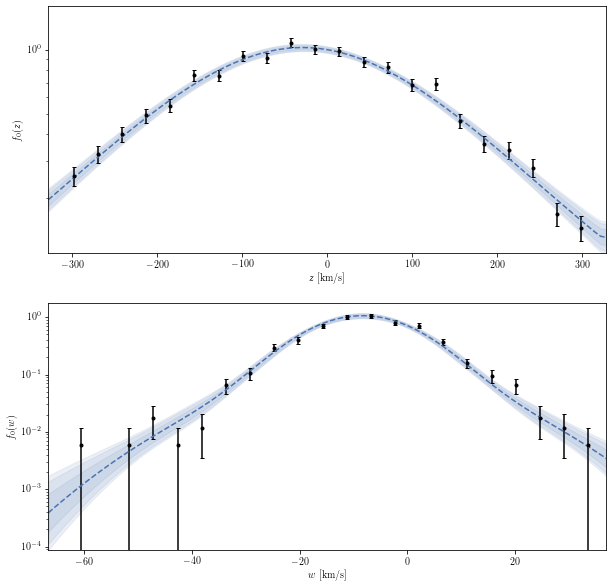

In [35]:
flat_chain = chain_thin.reshape(-1, ndim)

plot_fit(
    model=Model.DM,
    flat_chain=flat_chain,
    z_path=z_files[index],
    w_path=w_files[index],
    log=True,
    nsample=5_000,
    res=100
)

# calculate max likelihood

In [37]:
from datetime import datetime
from typing import Tuple

def calculate_prob(model: Model, zdata: Tuple[np.ndarray, np.ndarray, np.ndarray], wdata: Tuple[np.ndarray, np.ndarray, np.ndarray], flat_chain: np.ndarray, name: str, path: str, **options: dict):
    """
    Calculate maximum likelihood, BIC, and AIC, then save the result to a file

    Parameters
    ----------
    model: `Model` = `Model.DM`, `Model.DDDM`, or `Model.NO` \n
    zdata: ndarray = (zmid, znum, zerr) \n
    wdata: ndarray = (wmid, wnum, werr) \n
    flat_chain: ndarray(shape=(nsample, ndim)) \n
    path: `str` = path to save the result \n
    options:
        nsample: `int` = 10_000 \n
        verbose: `bool` = True \n
        batch: `int` = 1000 \n
    """
    nsample = options.get("nsample", 10_000)
    verbose = options.get("verbose", True)
    batch = options.get("batch", 1000)
    func = func_dict[model.value]
    if verbose: print("Opening the data")
    init = generate_init(model)
    locs = init['locs']
    scales = init['scales']
    if verbose: print("Opening the chain")
    length = len(flat_chain)
    sample = flat_chain[np.random.choice(length, nsample, replace=True)]
    # calculate likelihood
    if verbose: print("Calculating likelihood")
    probs = func.log_prob_par(sample, zdata, wdata, locs, scales, dz=1., batch=batch)
    likelihood = probs[:, 1]
    # remove nan from likelihood
    likelihood = likelihood[~np.isnan(likelihood)]
    max_likelihood = np.max(likelihood)
    # calculate BIC
    zmid = zdata[0]
    wmid = wdata[0]
    bic = -2 * max_likelihood + ndim * np.log(3*len(zmid) + 3*len(wmid))
    aic = -2 * max_likelihood + 2 * ndim
    print(f"max log-likelihood: {max_likelihood}")
    print(f"BIC: {bic}")
    print(f"AIC: {aic}")
    with open(path, 'a') as f:
        f.write(f"{name},{max_likelihood},{bic},{aic},{datetime.now()}\n")

In [41]:
calculate_prob(
    model=Model.DM, 
    zdata=zdata,
    wdata=wdata,
    flat_chain=flat_chain,
    name=name,
    path="tes.txt",
)

Opening the data
Opening the chain
Calculating likelihood
max log-likelihood: 94.73220641760727
BIC: -24.23079108691769
AIC: -121.46441283521455


# Script

do mcmc for

* same $N$, different $z$
* same $z$, different $N$

Each 'running' contains
1. generate_init: initial position for walkers.
    * this is done by the experiment above.
2. run_mcmc: run true mcmc for 10_000 steps.
3. plot trace: plot trace plot for preliminary mcmc.
4. plot corner: plot corner plot for the long run.
5. plot fit: fitting plot for vertical density and vertical dispersion.
6. calculate bic & aic: calculate bic and aic for the long run.

All of these functionalities are implemented in `mcmc.py` at `utils`.

Just run the `program.py` at `script`.
To automate the process for all data, run `run_program.py` at `script`.

# test utils

In [1]:
from os.path import abspath, join
from glob import glob
import sys
current = abspath("")
root_dir = abspath(join(current, '..', '..'))
root_data_dir = join(root_dir, "Data")
import sys
if not root_dir in sys.path: 
    sys.path.append(root_dir)

In [18]:
from utils import (style, get_params, mcmc, plot_chain, plot_corner, plot_fit, calculate_prob, get_data, Model)

style()

In [21]:
z_dir_path = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'n')
w_dir_path = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'n')
z_dir_path, w_dir_path

('/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/n',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/n')

In [4]:
print(mcmc.__doc__)


    Run MCMC

    Parameters
    ----------
    model: `Model` = `Model.DM`, `Model.DDDM`, or `Model.NO` 

    z_path: `str` = path to z data 

    w_path: `str` = path to w data 

    options:
        step0: `int` = 500 

        step: `int` = 2000 

        burn: `int` = 1000 

        it: `int` = 3 

        thin: `int` = 20 

        verbose: `bool` = True 

        m: `int` = 10 (multiplier, `nwalker = m*ndim`)
        
    Returns
    -------
    result: `dict` = { 

        indexes: `ndarray(shape(nparam))`, 

        labs: `ndarray(shape(nparam))`, 

        labels: `ndarray(shape(nparam))`, 

        chain: `ndarray(shape(nstep,nwalker,nparam))` 

    }
    


In [22]:
index = 5
z_files = glob(join(z_dir_path, "z*"))
z_files.sort()
w_files = glob(join(w_dir_path, "w*"))
w_files.sort()
name = z_files[index].split("/")[-1].replace(".hdf5", "").replace("z_", "")

result = mcmc(
    model=Model.DM,
    z_path=z_files[index],
    w_path=w_files[index],
    step0=100,
    step=1000,
    burn=1000,
    it=3,
    thin=20,
    m=10
)

result.keys()

running...
mcmc... 10000


mcmc:   0%|          | 0/3 [00:00<?, ?it/s]

0: first half mcmc done 2.23 s


mcmc:  33%|███▎      | 1/3 [00:04<00:08,  4.45s/it]

0: second half mcmc done 2.21 s
1: first half mcmc done 2.2 s


mcmc:  67%|██████▋   | 2/3 [00:08<00:04,  4.40s/it]

1: second half mcmc done 2.15 s
2: first half mcmc done 2.23 s


mcmc: 100%|██████████| 3/3 [00:13<00:00,  4.41s/it]

2: second half mcmc done 2.17 s


dict_keys(['indexes', 'labs', 'labels', 'chain'])

In [23]:
indexes, labs, labels, chain = result.values()
indexes, labs, labels

([range(0, 12), 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
 array(['rhob', 'rhoDM', 'log_nu0', 'R', 'zsun', 'w0', 'log_sigmaw',
        'q_sigmaw', 'log_a', 'q_a', 'log_phi_b'], dtype='<U32'),
 array(['$\\rho_{b}$', '$\\rho_{\\textup{DM}}$', '$\\log \\nu_0$', '$R$',
        '$z_{\\odot}$', '$w_0$', '$\\log \\sigma_{w}$', '$q_{w}$',
        '$\\log a$', '$q_a$', '$\\log \\Phi_b$'], dtype='<U32'))

In [7]:
print(plot_chain.__doc__)


    Plot the chains of the parameters.

    Parameters
    ----------
        params: `ndarray(shape=(nstep, nwalker, nparam))` (from `get_params`) 

        labels: `List[str]` 

        options:
            burn: `int` = 0 

            figsize: `Tuple[int, int]` = (10, 10) 

            path: `str` = None 

            alpha: `float` = 0.1 

            dpi: `int` = 70 

            fig_kw: `Dict` = All additional keyword arguments for `.pyplot.figure`.
            


100%|██████████| 11/11 [00:01<00:00,  7.35it/s]


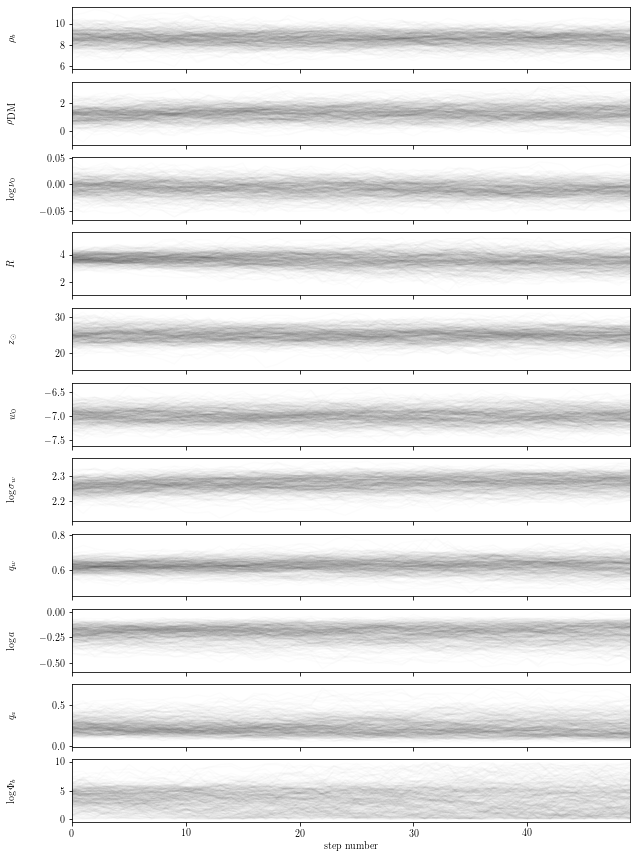

In [24]:
params = get_params(chain, indexes, labs)

plot_chain(
    params=params,
    labels=labels,
    alpha=0.01
)

In [9]:
print(plot_corner.__doc__)

required: 
            params: `ndarray(shape=(nstep, nwalker, nparam))` (from `get_params`) 

            labels: `List[str]` 

        options:
            burn: `int` = 0 

            path: `str` = None 

            dpi: `int` = 70 

            truths: `List[float]` = None (list of the real values) 

            corner_kw: `Dict` = All additional keyword arguments for `corner.corner`.


In [25]:
truths =[0.08889999999999998/1E-2, 
         1.60000000e-02/1E-2, 
         0.00000000e+00,  
         3.40000000e-03/1E-3,  
         3.00000000e+01,
        -7.00000000e+00,  
         2.30258509e+00,  
         5.00000000e-01, 
         -9.53101798e-02,
         1.00000000e-01,  
         3.23168032e+00]

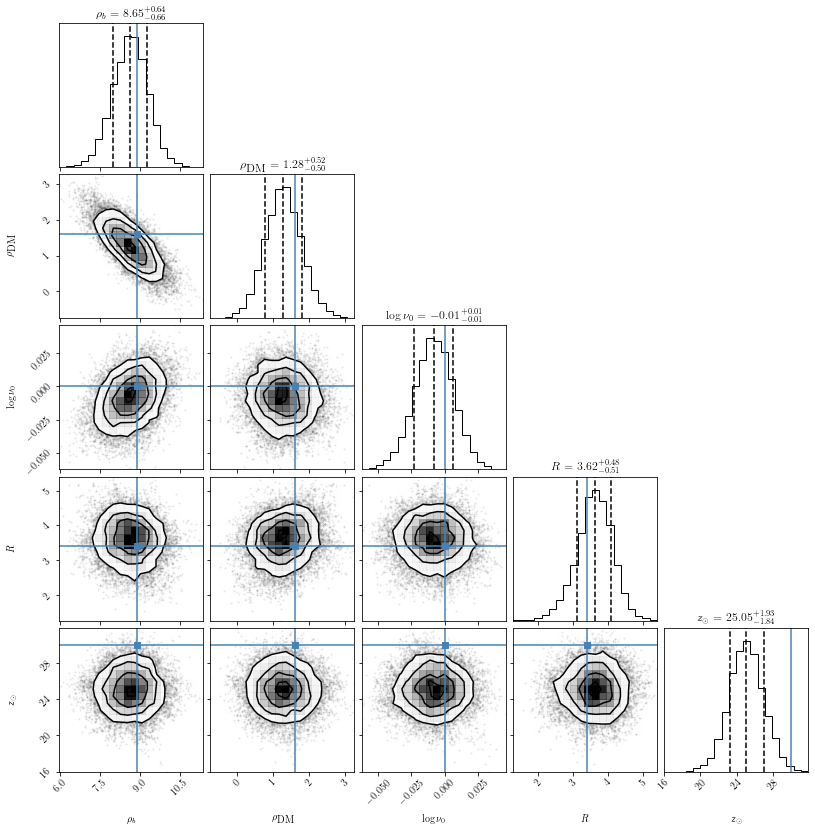

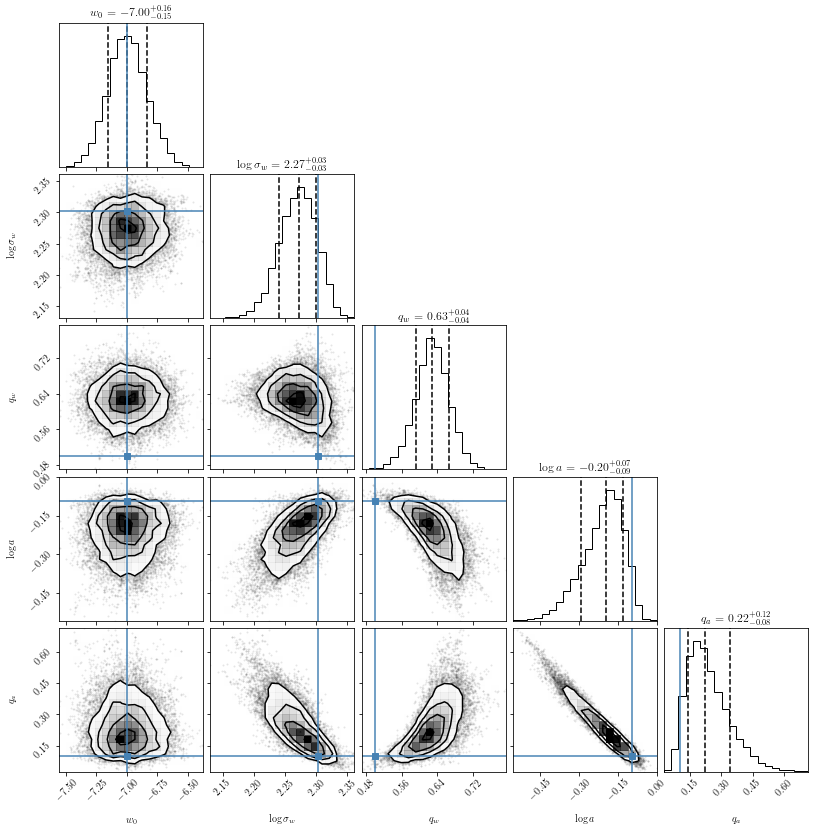

In [26]:
params = get_params(chain, indexes, labs)

# z
plot_corner(
    params=params[:,:,:5],
    labels=labels[:5],
    truths=truths[:5]
)
# w
plot_corner(
    params=params[:,:,5:-1],
    labels=labels[5:-1],
    truths=truths[5:-1]
)

In [14]:
print(plot_fit.__doc__) 

required: 
            model: `Model` = Model.DM 

            flat_chain: `ndarray(shape=(nsample, nparam))`

            z_path: `str` (path to z data)

            w_path: `str` (path to w data)

        options:
            res: `int` = 100 

            nsample: `int` = 5_000 

            figsize: `Tuple[int, int]` = (10, 10) 

            alpha: `float` = 0.1 

            c: `str` = C0 

            log: `bool` = False 

            dpi: `int` = 70 

            path: `str` = None 

            fig_kw: `Dict` = All additional keyword arguments for `.pyplot.figure`.
            


100%|██████████| 5000/5000 [00:02<00:00, 1895.60it/s]


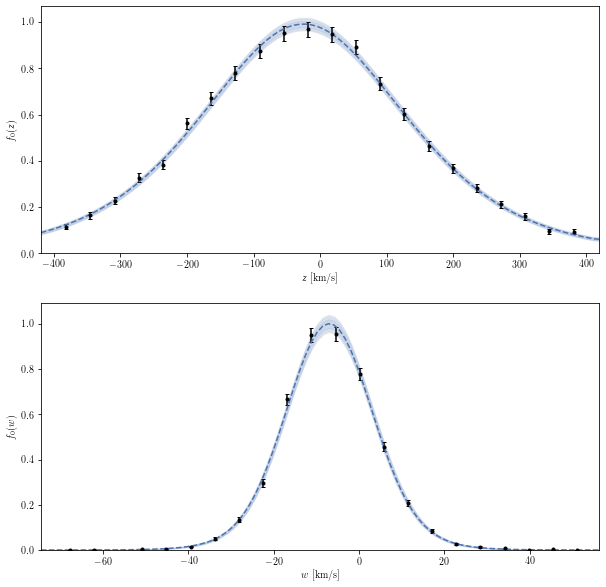

In [27]:
ndim = chain.shape[2]
flat_chain = chain.reshape((-1, ndim))

plot_fit(
    model=Model.DM,
    flat_chain=flat_chain,
    z_path=z_files[index],
    w_path=w_files[index],
    # log=True,
    nsample=5_000,
    res=100
)

In [14]:
print(calculate_prob.__doc__)

required: index, z_dir_path, phi_dir_path, model, flat, path
        optional:
            batch = 10_000
            nsample = 1_000
        .run to run the program


In [19]:
ndim = chain.shape[2]
flat_chain = chain.reshape((-1, ndim))
zdata = get_data(z_files[index])
wdata = get_data(w_files[index])

calculate_prob(
    model=Model.DM, 
    zdata=zdata,
    wdata=wdata,
    flat_chain=flat_chain,
    name=name,
    path="tes.txt",
)

Opening the data
Opening the chain
Calculating likelihood
max log-likelihood: 96.6744935091709
BIC: -28.115365270044947
AIC: -125.3489870183418
